# Machine Learning Final Project - Andrew Ebert

## Install and import packages

In [1]:
# Install dependencies
!pip install shap
!pip install tensorflow

     |████████████████████████████████| 1.2 MB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 9.1 MB/s  eta 0:00:01
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.11.2
    Uninstalling Pygments-2.11.2:
      Successfully uninstalled Pygments-2.11.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.6.0
    Uninstalling h5py-3.6.0:
      Successfully uninstalled h5py-3.6.0
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, accuracy_score, \
                            f1_score, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, \
GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from tensorflow import keras

2025-04-30 16:44:07.333545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 16:44:07.343373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 16:44:07.346328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 16:44:07.354082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Stage 1: Linear Models

## Regression Dataset (housing)

### Load, process, and adjust data

In [3]:
# Load dataset

housing_data = pd.read_csv('housing.csv')

display(housing_data)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


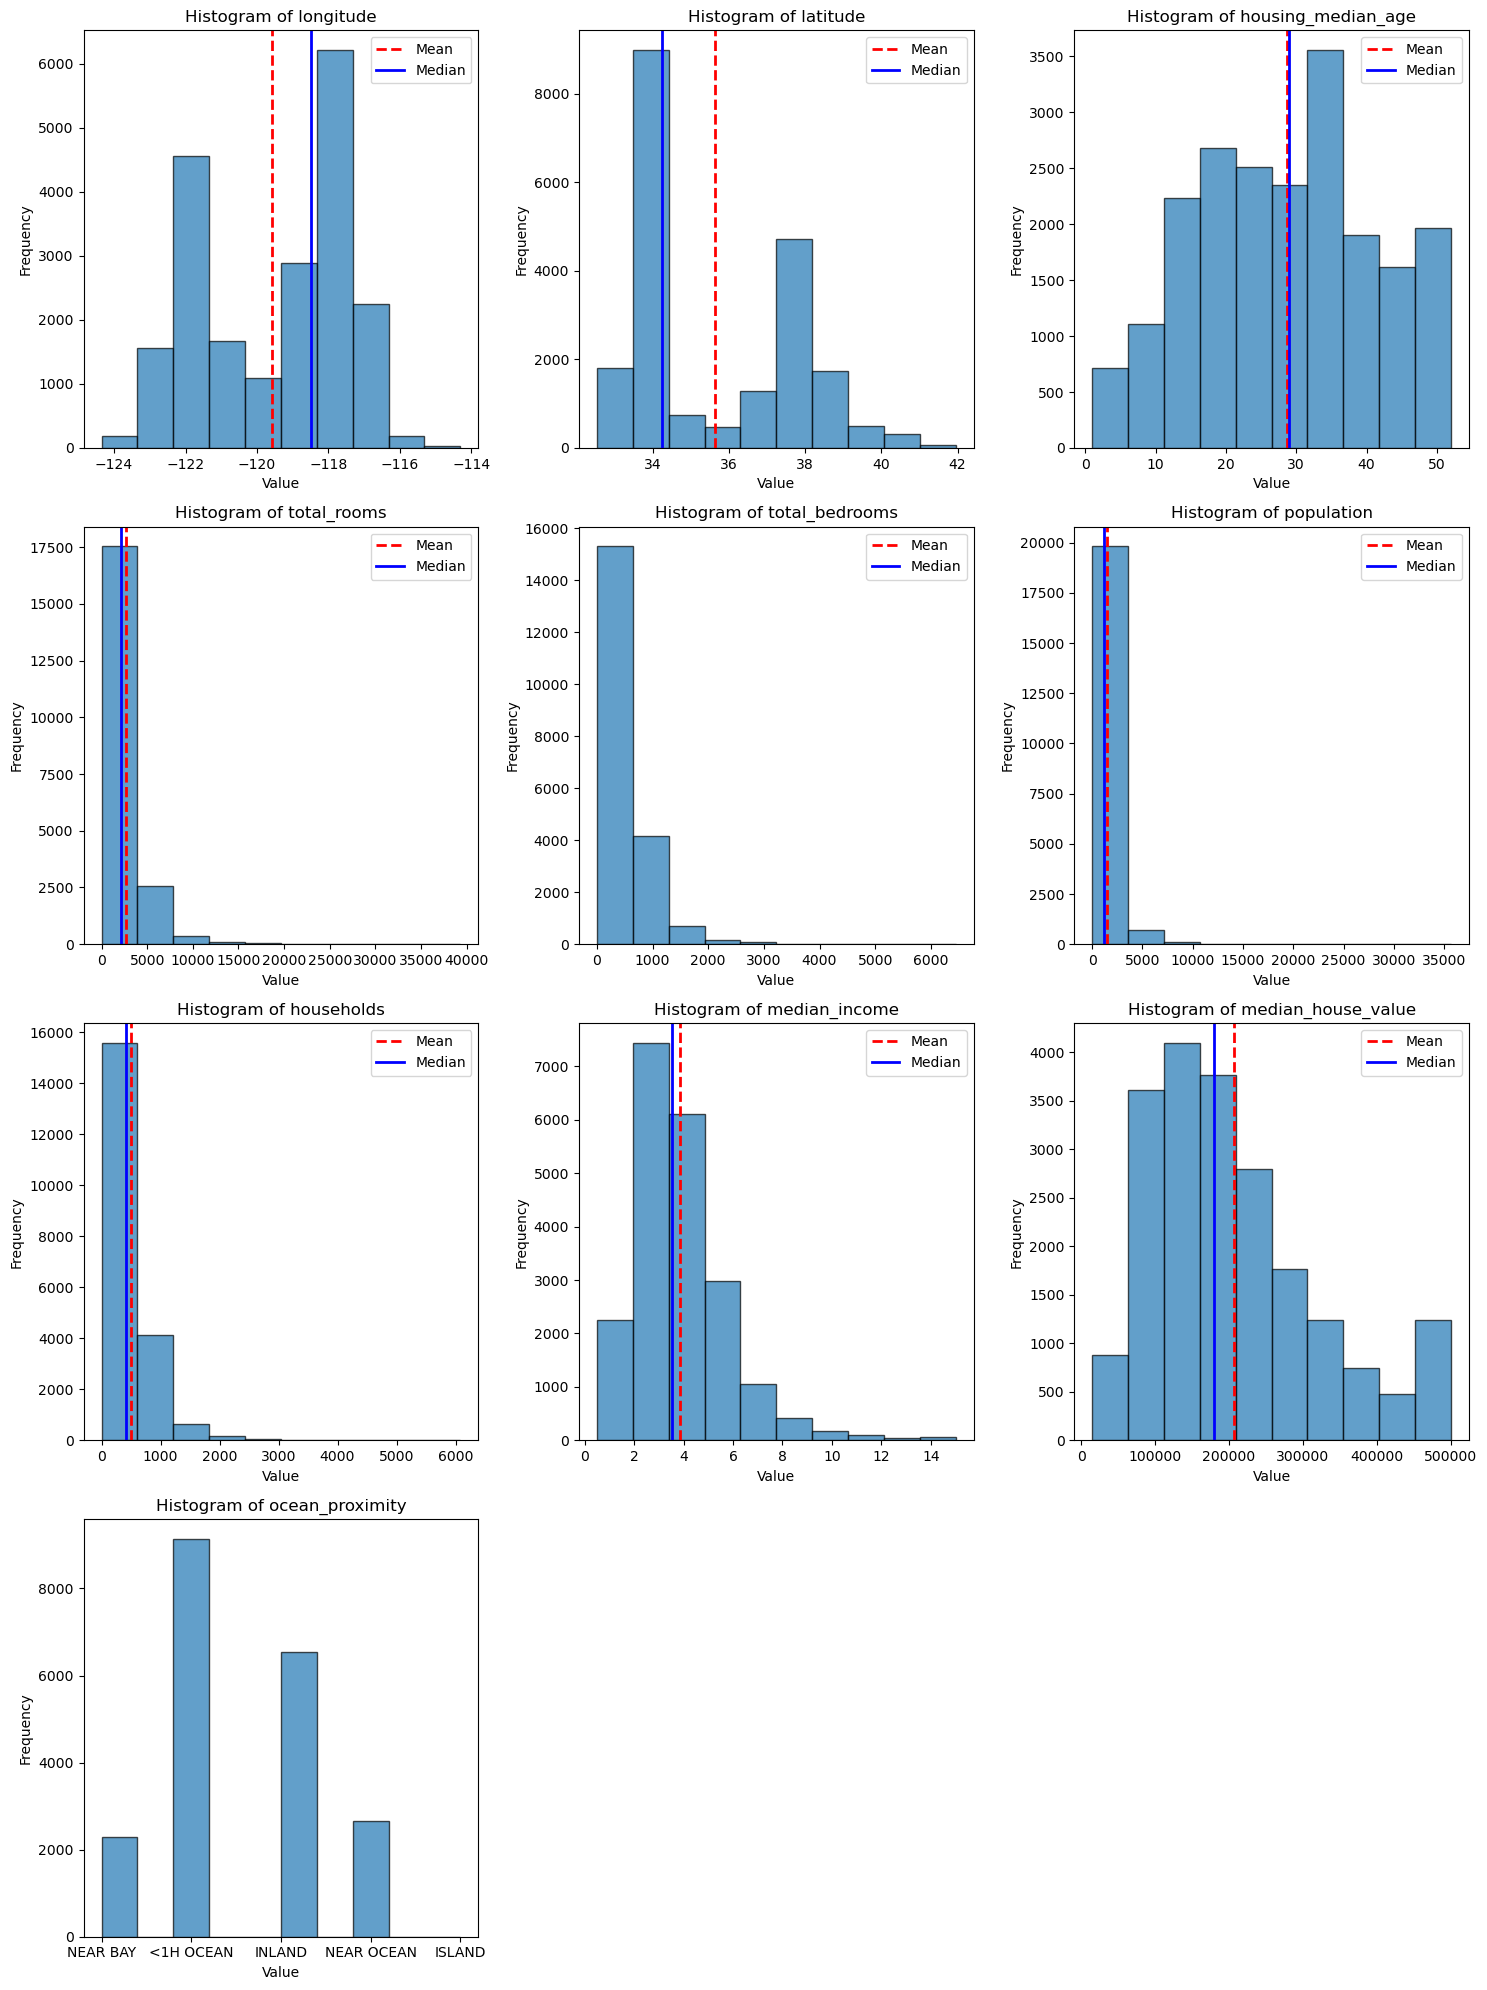

In [4]:
# EDA

# Set grid size
n_cols = 3
n_rows = (len(housing_data.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(housing_data.columns):
    ax = axes[i]
    data = housing_data[col].values

    ax.hist(data, bins=10, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {col}')

    # Add mean and median lines
    if col != 'ocean_proximity':
        mean_val = np.mean(data)
        median_val = np.median(data)
    
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label='Mean')
        ax.axvline(median_val, color='blue', linestyle='solid', linewidth=2, label='Median')
    
        # Add legend (only once per subplot)
        ax.legend()

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [5]:
# Display columns with missing values

print(housing_data.isna().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [6]:
# Analyze categorical, numeric

housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# Convert categorical variables to numeric (ocean_proximity)

unique_categories = housing_data['ocean_proximity'].unique()

encoder = LabelEncoder()

encoded_categories = encoder.fit_transform(unique_categories)

housing_data['ocean_proximity'] = encoder.fit_transform(housing_data['ocean_proximity'])

In [8]:
# Initialize features and target

input_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                 'population', 'households', 'median_income', 'ocean_proximity']

target = 'median_house_value'

In [9]:
'''
Train_test split features/target
First implementation is removing rows with total_bedrooms == na
'''

housing_data_na_removed = housing_data.dropna()

X_train_lin_reg1, X_test_lin_reg1, y_train_lin_reg1, y_test_lin_reg1 = \
train_test_split(housing_data_na_removed[input_features], housing_data_na_removed[target],
test_size=0.25,
random_state=5)

In [10]:
# Evaluate model performance

model1 = LinearRegression()
model1.fit(X_train_lin_reg1, y_train_lin_reg1)
y1_pred = model1.predict(X_test_lin_reg1)

print(f'Metrics for case 1')
print(f'R2 score: {r2_score(y_test_lin_reg1, y1_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg1, y1_pred))}')

Metrics for case 1
R2 score: 0.637347156171301
RMSE: 69996.90089337056


In [11]:
'''
Train_test split features/target
Second is filling in rows with total_bedrooms == na with average total_bedrooms
'''

housing_data_bedrooms_mean = housing_data.copy()

total_bedrooms_mean = housing_data['total_bedrooms'].mean()

housing_data_bedrooms_mean['total_bedrooms'] = \
    housing_data_bedrooms_mean['total_bedrooms'].fillna(total_bedrooms_mean)

X_train_lin_reg2, X_test_lin_reg2, y_train_lin_reg2, y_test_lin_reg2 = \
train_test_split(housing_data_bedrooms_mean[input_features], housing_data_bedrooms_mean[target],
test_size=0.25,
random_state=5)

In [12]:
# Evaluate model performance

model2 = LinearRegression()
model2.fit(X_train_lin_reg2, y_train_lin_reg2)
y2_pred = model2.predict(X_test_lin_reg2)

print(f'Metrics for case 2')
print(f'R2 score: {r2_score(y_test_lin_reg2, y2_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg2, y2_pred))}')

Metrics for case 2
R2 score: 0.6411224481450131
RMSE: 70091.31778275003


In [13]:
'''
Train_test split features/target
Third implentation is filling in rows with total_bedrooms == na with 
total_rooms * (avg(total_rooms / total_bedrooms))
'''

housing_data_bedrooms_proportionally = housing_data.copy()

total_rooms_sum = housing_data.loc[housing_data['total_bedrooms'].notna(), 'total_rooms'].sum()

total_bedrooms_sum = housing_data['total_bedrooms'].sum()

proportion = total_bedrooms_sum / total_rooms_sum

housing_data_bedrooms_proportionally['total_bedrooms'] = housing_data_bedrooms_proportionally.apply(
    lambda row: row['total_rooms'] * proportion if pd.isna(row['total_bedrooms']) else row['total_bedrooms'], axis=1
)

X_train_lin_reg3, X_test_lin_reg3, y_train_lin_reg3, y_test_lin_reg3 = \
train_test_split(housing_data_bedrooms_proportionally[input_features], housing_data_bedrooms_proportionally[target],
test_size=0.25,
random_state=5)

In [14]:
# Evaluate model performance

model3 = LinearRegression()
model3.fit(X_train_lin_reg3, y_train_lin_reg3)
y3_pred = model3.predict(X_test_lin_reg3)

print(f'Metrics for case 3')
print(f'R2 score: {r2_score(y_test_lin_reg3, y3_pred)}')
print(f'Mean squared error: {mean_squared_error(y_test_lin_reg3, y3_pred)}')

Metrics for case 3
R2 score: 0.6428052957492465
Mean squared error: 4889755774.243518


### Fit model 3 without each feature (manually determine features improving/hurting model performance)

In [15]:
# Train/test models

for feature in input_features:

    X_train = X_train_lin_reg3.drop(columns=feature)
    X_test = X_test_lin_reg3.drop(columns=feature)

    model = LinearRegression()
    model.fit(X_train, y_train_lin_reg3)
    y_pred = model.predict(X_test)

    print(f'Metrics without feature {feature}')
    print(f'R2 score: {r2_score(y_test_lin_reg3, y_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg3, y_pred))}')
    print('\n')

Metrics without feature longitude
R2 score: 0.5833330977078929
RMSE: 75524.10377737663


Metrics without feature latitude
R2 score: 0.574739790790735
RMSE: 76298.93089537226


Metrics without feature housing_median_age
R2 score: 0.6283099581562898
RMSE: 71331.53031807752


Metrics without feature total_rooms
R2 score: 0.6420054570705138
RMSE: 70005.03573996098


Metrics without feature total_bedrooms
R2 score: 0.6376969560490189
RMSE: 70425.03472728007


Metrics without feature population
R2 score: 0.6216402146513886
RMSE: 71968.68436884481


Metrics without feature households
R2 score: 0.643256105458396
RMSE: 69882.6480027825


Metrics without feature median_income
R2 score: 0.38865722647610657
RMSE: 91481.54061972754


Metrics without feature ocean_proximity
R2 score: 0.6429683580443621
RMSE: 69910.82577727639




### Fit model 3 without features that have better accuracy when removed

In [16]:
# Train/test model

features = ['households', 'ocean_proximity']

X_train = X_train_lin_reg3.drop(columns=features)
X_test = X_test_lin_reg3.drop(columns=features)

model = LinearRegression()
model.fit(X_train, y_train_lin_reg3)
y_pred = model.predict(X_test)

print(f'Metrics without features {features}')
print(f'R2 score: {r2_score(y_test_lin_reg3, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg3, y_pred))}')

Metrics without features ['households', 'ocean_proximity']
R2 score: 0.6433934009267874
RMSE: 69869.19928740225


### Implement pipeline, experimenting with preprocessing (StandardScaler) and polynomial features

In [17]:
# Implement model 3 with pipeline for preprocessing and polynomial features

best_degree = 1
best_score = -np.inf
degrees = range(1, 6)

r2_scores = []
mse_scores = []
cv_scores_list = []


for degree in degrees:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree = degree)),
    ('lin_reg', LinearRegression())
])

    pipeline.fit(X_train, y_train_lin_reg3)
    
    y_pred = pipeline.predict(X_test)

    cv_scores = cross_val_score(pipeline, X_train, y_train_lin_reg3, cv=5, scoring='r2')

    avg_cv = np.mean(cv_scores)
    r2 = r2_score(y_test_lin_reg3, y_pred)
    mse = mean_squared_error(y_test_lin_reg3, y_pred)
    
    # Store the results for plotting
    r2_scores.append(r2)
    mse_scores.append(mse)
    cv_scores_list.append(avg_cv)

    if avg_cv > best_score:
        best_score = avg_cv
        best_degree = degree

    print(f'Metrics for degree {degree}')
    print(f'R2 score: {r2}')
    print(f'Mean squared error: {mse}')
    print(f'Average CV score: {avg_cv}')
    print('\n')

print(f'Best degree: {best_degree}')

Metrics for degree 1
R2 score: 0.6433934009267889
Mean squared error: 4881705009.062711
Average CV score: 0.6314071527498857


Metrics for degree 2
R2 score: 0.6976254071570194
Mean squared error: 4139305240.932554
Average CV score: 0.5324911860482157


Metrics for degree 3
R2 score: 0.4438173816486717
Mean squared error: 7613766769.924191
Average CV score: -2.2372457144659004


Metrics for degree 4
R2 score: -15.853715343744796
Mean squared error: 230716051886.59186
Average CV score: -714.1427405624086


Metrics for degree 5
R2 score: -5119.628556382942
Mean squared error: 70097968288332.83
Average CV score: -64638.60896179559


Best degree: 1


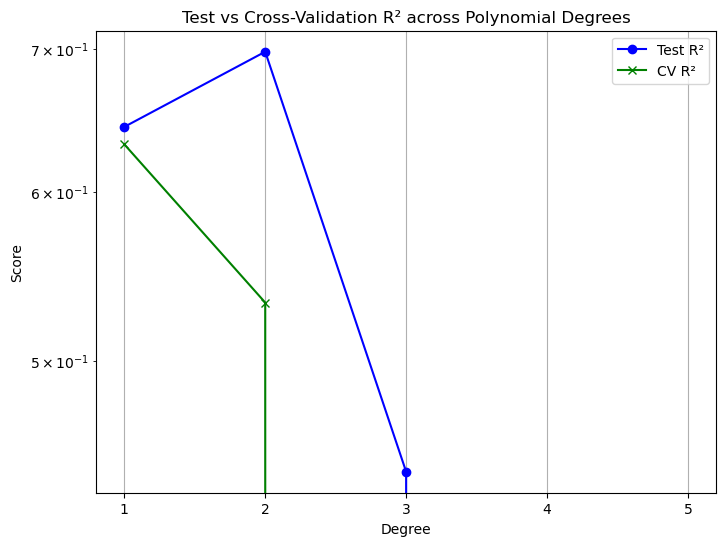

In [18]:
# Plot R^2 and CV

plt.figure(figsize=(8,6))

plt.plot(degrees, r2_scores, marker='o', label='Test R²', color='blue')
plt.plot(degrees, cv_scores_list, marker='x', label='CV R²', color='green')

plt.xlabel('Degree')
plt.ylabel('Score')
plt.title('Test vs Cross-Validation R² across Polynomial Degrees')
plt.xticks(degrees)
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

### Regularization using Ridge and Lasso

In [19]:
# Almost identical to the cell above except we are implementing Ridge vs LinearRegression

pipeline = Pipeline([
('scaler', StandardScaler()),
('poly', PolynomialFeatures(degree = 1)),
('ridge', Ridge(alpha=1.0))
])

pipeline.fit(X_train, y_train_lin_reg3)
    
y_pred = pipeline.predict(X_test)

cv_scores = cross_val_score(pipeline, X_train, y_train_lin_reg3, cv=5, scoring='r2')

avg_cv = np.mean(cv_scores)


print(f'Metrics for degree 1')
print(f'R2 score: {r2_score(y_test_lin_reg3, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg3, y_pred))}')
print(f'Average CV score: {avg_cv}')

Metrics for degree 1
R2 score: 0.6433939424865336
RMSE: 69869.14623403715
Average CV score: 0.6314099116864842


In [20]:
# Almost identical to the cell above except we are implementing Lasso vs LinearRegression

pipeline = Pipeline([
('scaler', StandardScaler()),
('poly', PolynomialFeatures(degree = 1)),
('lasso', Lasso(alpha=0.01, max_iter=10000))
])

pipeline.fit(X_train, y_train_lin_reg3)
    
y_pred = pipeline.predict(X_test)

cv_scores = cross_val_score(pipeline, X_train, y_train_lin_reg3, cv=5, scoring='r2')

avg_cv = np.mean(cv_scores)

print(f'Metrics for degree 1')
print(f'R2 score: {r2_score(y_test_lin_reg3, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg3, y_pred))}')
print(f'Average CV score: {avg_cv}')

Metrics for degree 1
R2 score: 0.6433934021052949
RMSE: 69869.19917195097
Average CV score: 0.6314071573182629


### Visualization

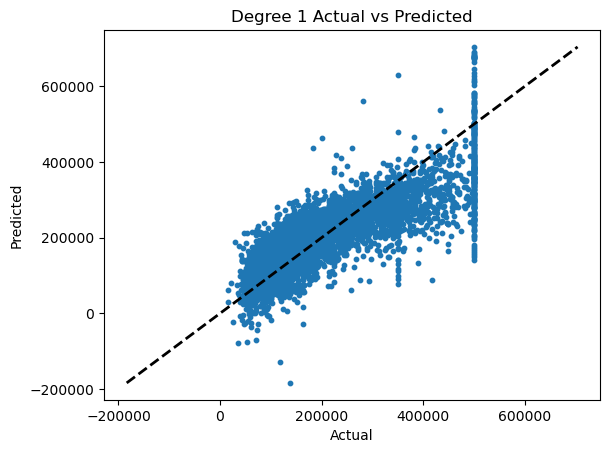

In [21]:
# Degree 1 plot

X_train = X_train_lin_reg3.drop(columns=features)
X_test = X_test_lin_reg3.drop(columns=features)

model = LinearRegression()
model.fit(X_train, y_train_lin_reg3)
y_pred = model.predict(X_test)

# Flatten if needed
y_test_flat = y_test_lin_reg3.to_numpy().flatten()
y_pred_flat = y_pred.flatten()

# Scatter plot
plt.scatter(y_test_flat, y_pred_flat, s=10)
min_val = min(y_test_flat.min(), y_pred_flat.min())
max_val = max(y_test_flat.max(), y_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Degree 1 Actual vs Predicted')
plt.show()

/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e+13, tolerance: 2.042e+10
  model = cd_fast.enet_coordinate_descent(


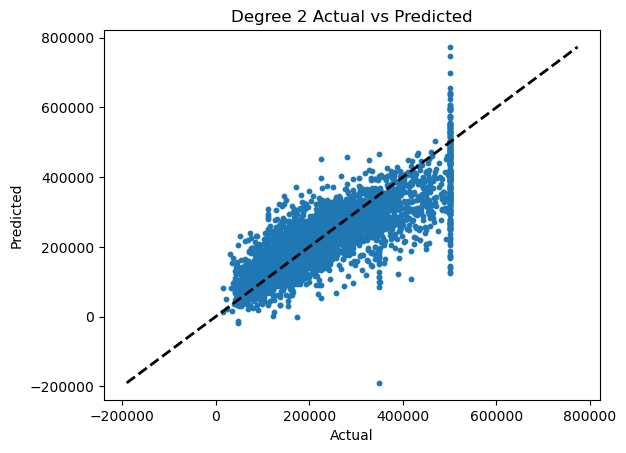

In [22]:
# Degree 2 plot

pipeline = Pipeline([
('scaler', StandardScaler()),
('poly', PolynomialFeatures(degree = 2)),
('lasso', Lasso(alpha=0.01, max_iter=10000))
])

pipeline.fit(X_train, y_train_lin_reg3)
    
y_pred = pipeline.predict(X_test)

# Flatten if needed
y_test_flat = y_test_lin_reg3.to_numpy().flatten()
y_pred_flat = y_pred.flatten()

# Scatter plot
plt.scatter(y_test_flat, y_pred_flat, s=10)
min_val = min(y_test_flat.min(), y_pred_flat.min())
max_val = max(y_test_flat.max(), y_pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Degree 2 Actual vs Predicted')
plt.show()

## Classification Dataset (loan)

### Load, process, and adjust data

In [23]:
# Load dataset

loan_data = pd.read_csv('loan.csv')

display(loan_data)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


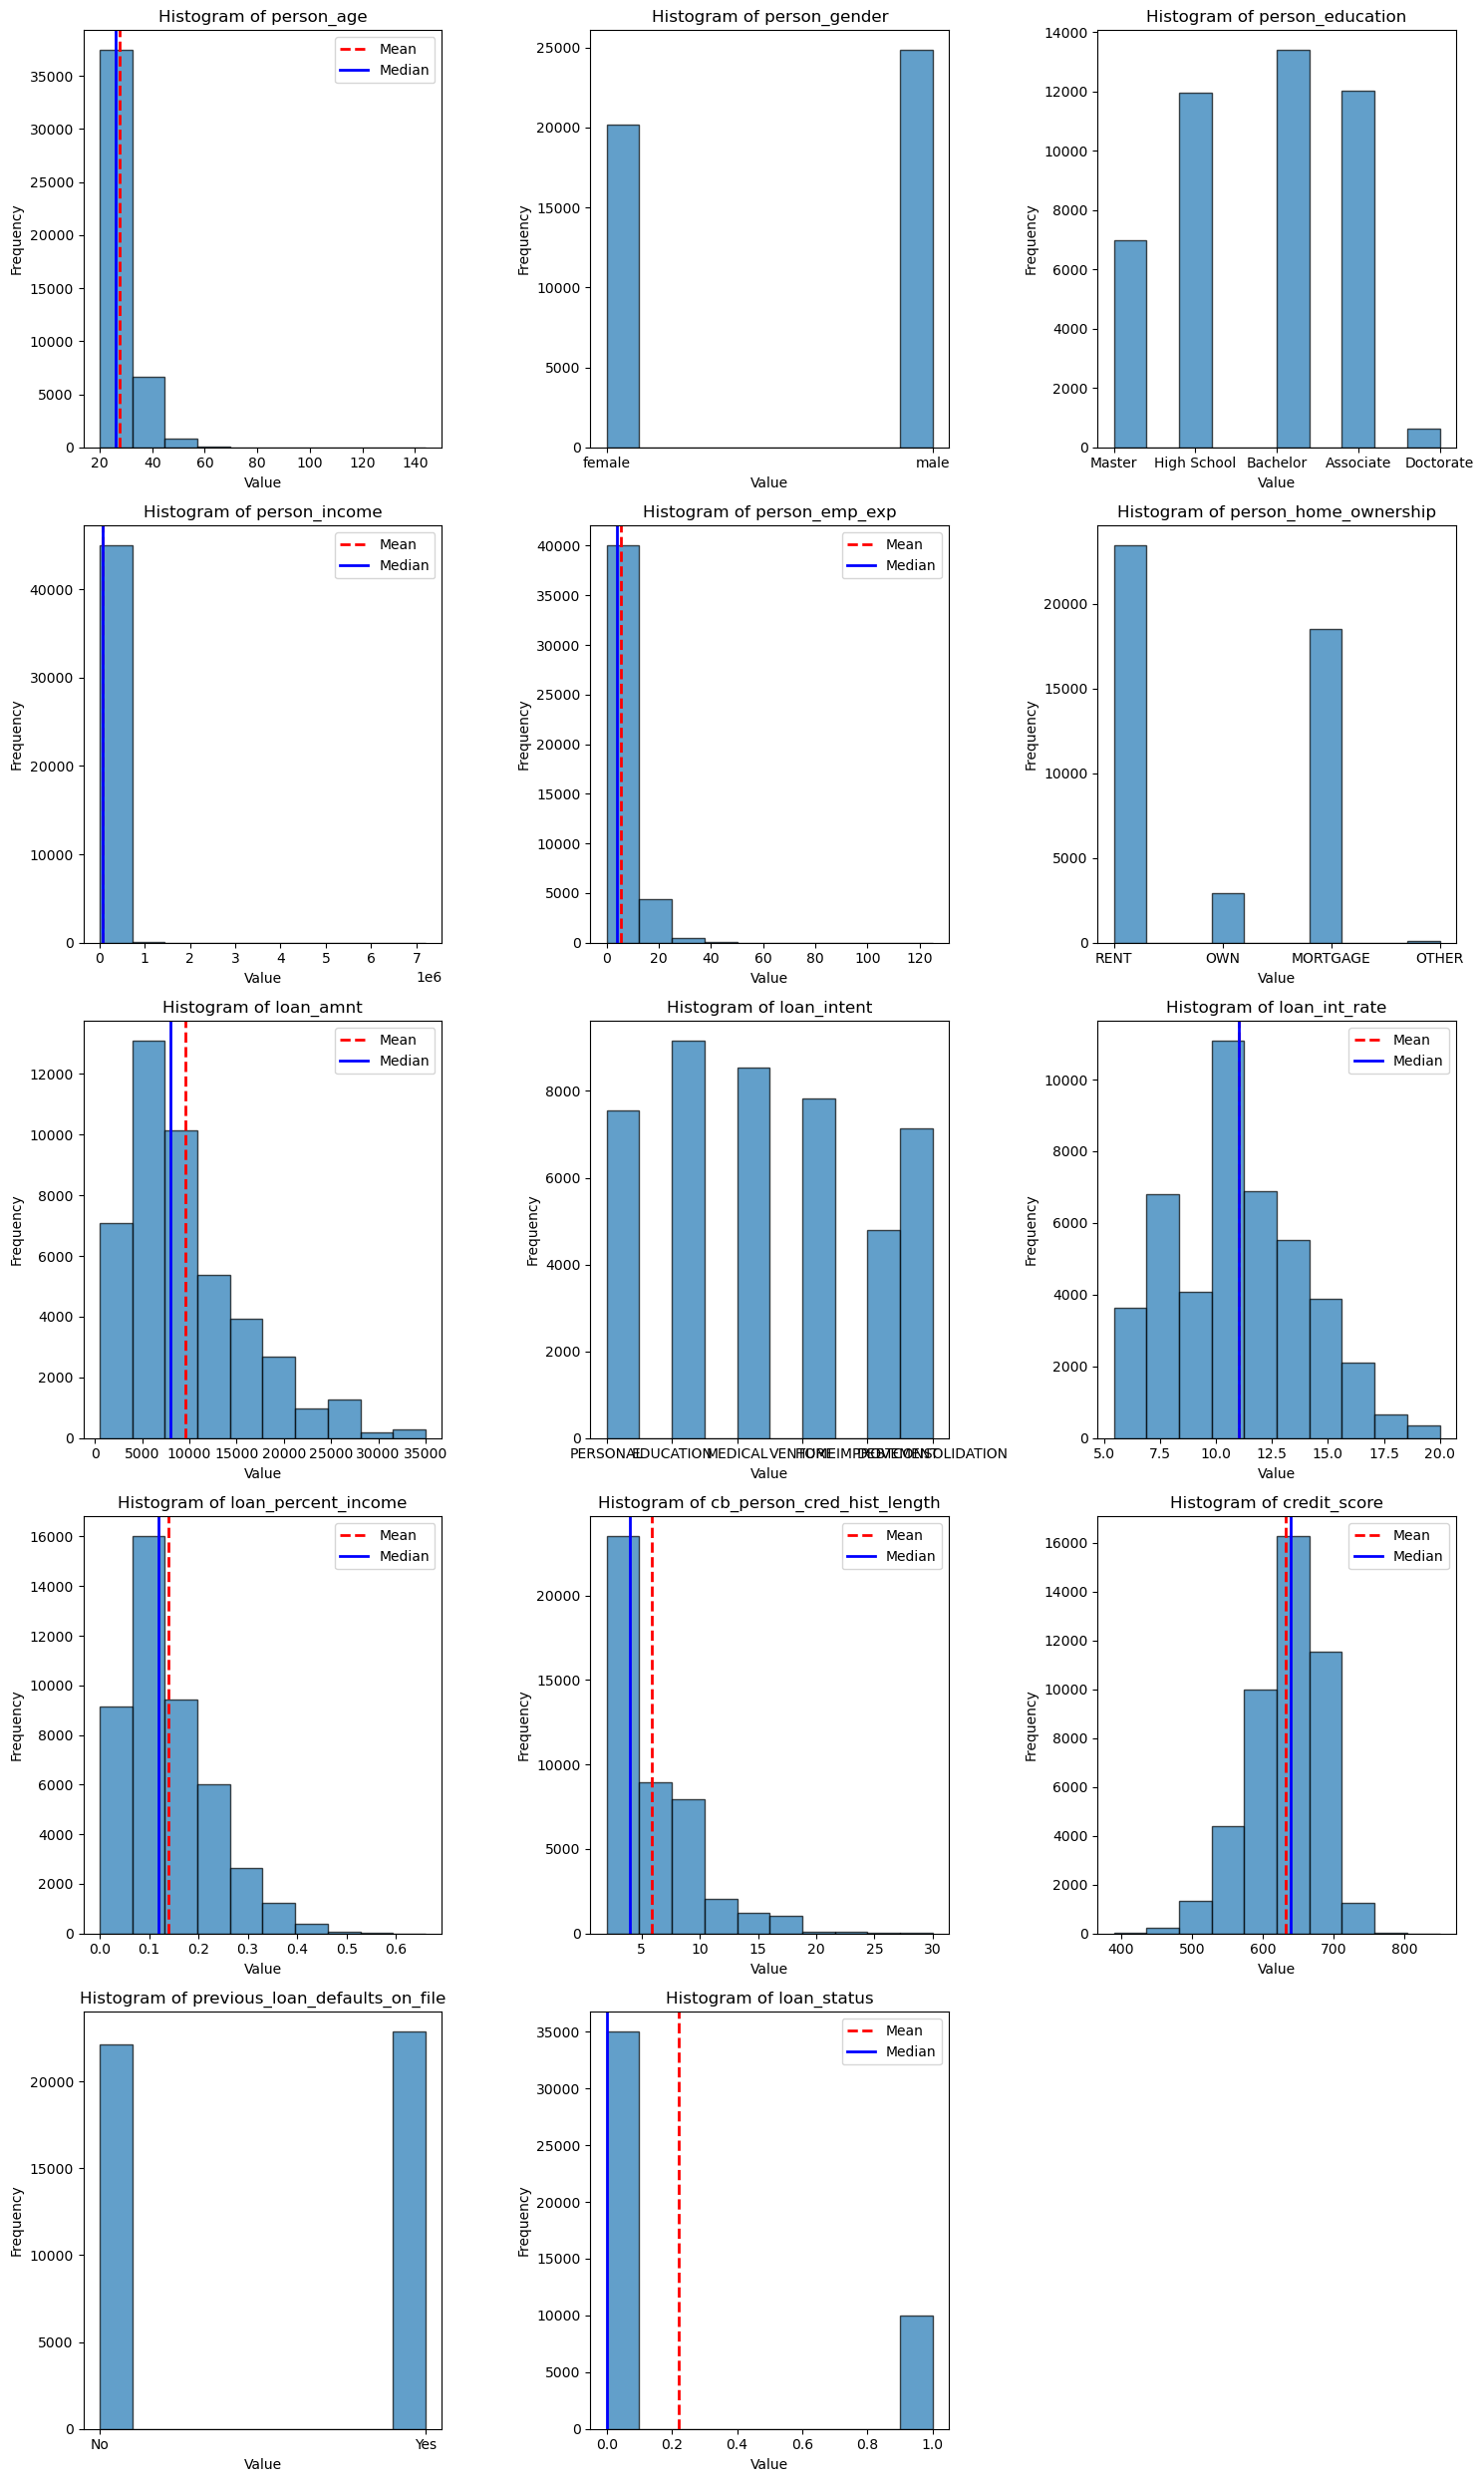

In [24]:
# EDA

# Set grid size
n_cols = 3
n_rows = (len(loan_data.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(loan_data.columns):
    ax = axes[i]
    data = loan_data[col].values

    ax.hist(data, bins=10, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {col}')

    # Add mean and median lines
    if col not in ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']:
        mean_val = np.mean(data)
        median_val = np.median(data)
    
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label='Mean')
        ax.axvline(median_val, color='blue', linestyle='solid', linewidth=2, label='Median')
    
        # Add legend (only once per subplot)
        ax.legend()

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [25]:
# Display columns with missing values

print(loan_data.isna().sum())

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


In [26]:
# Analyze numeric, categorical

loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [27]:
# Visualize unique identifiers for categorical

categorical = {'person_gender':[], 'person_education':[], 'person_home_ownership':[], 
               'loan_intent':[], 'previous_loan_defaults_on_file':[]}


for _, row in loan_data.iterrows():  
    for column_name in categorical.keys():
        value = row[column_name]
        if value not in categorical[column_name]:
            categorical[column_name].append(value)

# Print results
for key, value in categorical.items():
    print(f'Key: {key}, values: {value}')

Key: person_gender, values: ['female', 'male']
Key: person_education, values: ['Master', 'High School', 'Bachelor', 'Associate', 'Doctorate']
Key: person_home_ownership, values: ['RENT', 'OWN', 'MORTGAGE', 'OTHER']
Key: loan_intent, values: ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
Key: previous_loan_defaults_on_file, values: ['No', 'Yes']


In [28]:
# Convert categorical to numeric

loan_data['person_gender'].replace(['female', 'male'],
                        [0, 1], inplace=True)
loan_data['person_education'].replace(['Master', 'High School', 'Bachelor', 'Associate', 'Doctorate'],
                        [0, 1, 2, 3, 4], inplace=True)
loan_data['person_home_ownership'].replace(['RENT', 'OWN', 'MORTGAGE', 'OTHER'],
                        [0, 1, 2, 3], inplace=True)
loan_data['loan_intent'].replace(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION'],
                        [0, 1, 2, 3, 4, 5], inplace=True)
loan_data['previous_loan_defaults_on_file'].replace(['No', 'Yes'],
                        [0, 1], inplace=True)

display(loan_data)

/tmp/ipykernel_144341/285946259.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['person_gender'].replace(['female', 'male'],
/tmp/ipykernel_144341/285946259.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_data['person_gender'].replace(['female', 'male'],
/tmp/ipykernel_144341/

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,0,71948.0,0,0,35000.0,0,16.02,0.49,3.0,561,0,1
1,21.0,0,1,12282.0,0,1,1000.0,1,11.14,0.08,2.0,504,1,0
2,25.0,0,1,12438.0,3,2,5500.0,2,12.87,0.44,3.0,635,0,1
3,23.0,0,2,79753.0,0,0,35000.0,2,15.23,0.44,2.0,675,0,1
4,24.0,1,0,66135.0,1,0,35000.0,2,14.27,0.53,4.0,586,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,1,3,47971.0,6,0,15000.0,2,15.66,0.31,3.0,645,0,1
44996,37.0,0,3,65800.0,17,0,9000.0,4,14.07,0.14,11.0,621,0,1
44997,33.0,1,3,56942.0,7,0,2771.0,5,10.02,0.05,10.0,668,0,1
44998,29.0,1,2,33164.0,4,0,12000.0,1,13.23,0.36,6.0,604,0,1


In [29]:
# Initialize features and target

input_features = ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp',
                 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income',
                 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file']

target = 'loan_status'

### Train, test, and evaluate

In [30]:
# Train/test split

X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = \
train_test_split(loan_data[input_features], loan_data[target],
test_size=0.25,
random_state=5)

In [31]:
# LogisticRegression Model

model = LogisticRegression(max_iter=1000)
model.fit(X_train_logistic, y_train_logistic)

slope = model.coef_[0]
intercept = model.intercept_

print(f"Slope (w): {slope}")
print(f"Intercept (w_0): {intercept}")

Slope (w): [ 6.80097424e-02  1.49371337e-02  5.77334168e-02 -2.19297315e-05
 -2.52764964e-02 -4.28704097e-01  9.31741545e-05 -8.39037122e-03
  3.55889538e-01  2.80544629e-01 -1.26207906e-01 -7.16652419e-03
 -5.37647847e+00]
Intercept (w_0): [-0.06396868]


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Evaluate model performance

y_pred = model.predict(X_test_logistic)
accuracy = accuracy_score(y_test_logistic, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8732


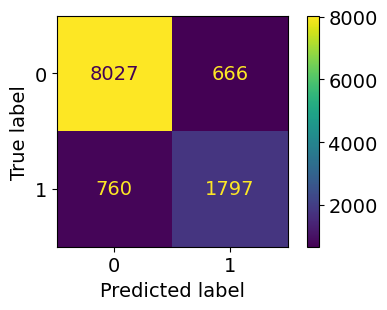

In [33]:
# Plot confusion matrix

plt.rcParams.update({'font.size': 14, "figure.figsize": (5,3)})

ConfusionMatrixDisplay.from_predictions(y_test_logistic, y_pred)

plt.show()

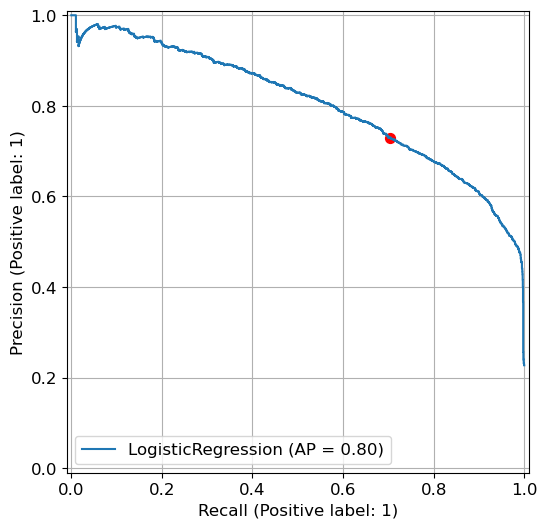

In [34]:
# Plot precision/recall

plt.rcParams.update({'font.size': 12, "figure.figsize": (7,6)})

PrecisionRecallDisplay.from_estimator(model, X_test_logistic, y_test_logistic)

plt.scatter(recall_score(y_test_logistic, y_pred), precision_score(y_test_logistic, y_pred), c = 'r', s=50)

plt.grid()

plt.show()

### Fit model without each feature

In [35]:
# Get model accuracy removing each feature at a time

for feature in input_features:

    X_train_subset = X_train_logistic.drop(columns=feature)
    X_test_subset = X_test_logistic.drop(columns=feature)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_subset, y_train_logistic)
    y_pred = model.predict(X_test_subset)
    
    accuracy = accuracy_score(y_test_logistic, y_pred)

    print(f'Metrics without feature {feature}')
    print(f'Accuracy: {accuracy:.4f}')

X_train_subset = X_train_logistic.drop(columns=['person_age', 'person_gender', 'person_income', 'person_emp_exp', 'person_home_ownership',
                                                'loan_amnt', 'cb_person_cred_hist_length', 'credit_score'])
X_test_subset = X_test_logistic.drop(columns=['person_age', 'person_gender', 'person_income', 'person_emp_exp', 'person_home_ownership',
                                                'loan_amnt', 'cb_person_cred_hist_length', 'credit_score'])

model = LogisticRegression(max_iter=1000)
model.fit(X_train_subset, y_train_logistic)
y_pred = model.predict(X_test_subset)
    
accuracy = accuracy_score(y_test_logistic, y_pred)

print(f'Metrics without feature {feature}')
print(f'Accuracy: {accuracy:.4f}')

/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature person_age
Accuracy: 0.8753


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature person_gender
Accuracy: 0.8779


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature person_education
Accuracy: 0.8732


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature person_income
Accuracy: 0.8737


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature person_emp_exp
Accuracy: 0.8776


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature person_home_ownership
Accuracy: 0.8760


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature loan_amnt
Accuracy: 0.8748


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature loan_intent
Accuracy: 0.8746


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature loan_int_rate
Accuracy: 0.8548


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature loan_percent_income
Accuracy: 0.8724


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature cb_person_cred_hist_length
Accuracy: 0.8772


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics without feature credit_score
Accuracy: 0.8744
Metrics without feature previous_loan_defaults_on_file
Accuracy: 0.8268
Metrics without feature previous_loan_defaults_on_file
Accuracy: 0.8774


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Train, test, and evaluate with adjustments for optimal accuracy

In [36]:
# Adjust recall threshold

X_train, X_test, y_train, y_test = \
train_test_split(loan_data[input_features], loan_data[target],
test_size=0.25,
random_state=5)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

idx = np.argmin(np.abs(recall - 0.51))
optimal_threshold = thresholds[idx]

print(f"Optimal threshold for recall ≈ 0.6: {optimal_threshold}")

y_pred_new = (y_prob > optimal_threshold).astype(int)

Optimal threshold for recall ≈ 0.6: 0.6696058482158803


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# Evaluate new pred performance

accuracy = accuracy_score(y_test, y_pred_new)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8639


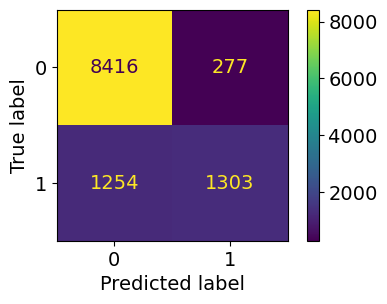

In [38]:
# Plot confusion matrix

plt.rcParams.update({'font.size': 14, "figure.figsize": (5,3)})

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_new)

plt.show()

### Train, test, and evaluate with adjustments for improved proportional accuracy

Accuracy: 0.8480


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


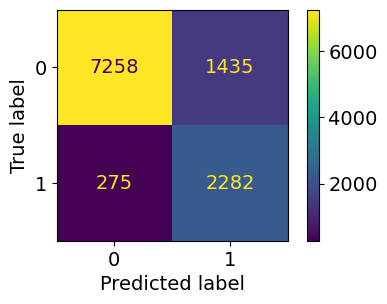

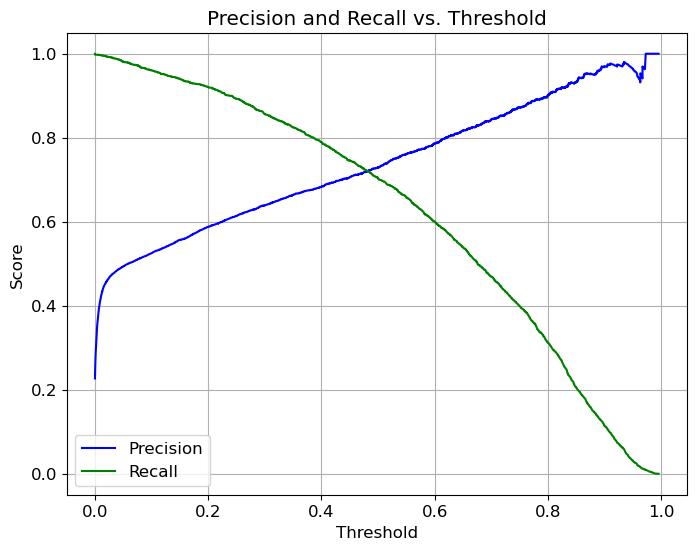

In [39]:
'''
Finetuning to have better accuracy proportional to classes 
(limit class 0 dominating due to frequency)
Make custom predictions based on custom threshold
(determined through trial and error)
'''

X_train, X_test, y_train, y_test = \
train_test_split(loan_data[input_features], loan_data[target],
test_size=0.25,
random_state=5)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
optimal_threshold = 0.25
y_pred_new = (y_prob > optimal_threshold).astype(int)

accuracy = accuracy_score(y_test_logistic, y_pred_new)
print(f'Accuracy: {accuracy:.4f}')

# Plot confusion matrix
plt.rcParams.update({'font.size': 14, "figure.figsize": (5,3)})
ConfusionMatrixDisplay.from_predictions(y_test_logistic, y_pred_new)
plt.show()

# Plot Precision/Recall vs Threshold
plt.rcParams.update({'font.size': 12, "figure.figsize": (7,6)})
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Train, test, and evaluate code above removing features that improved accuracy when removed (from above)

Accuracy: 0.8137


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


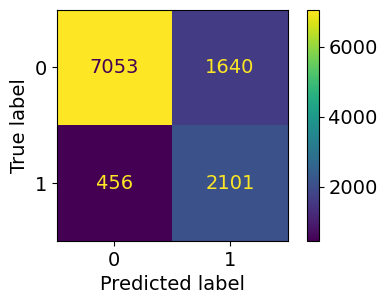

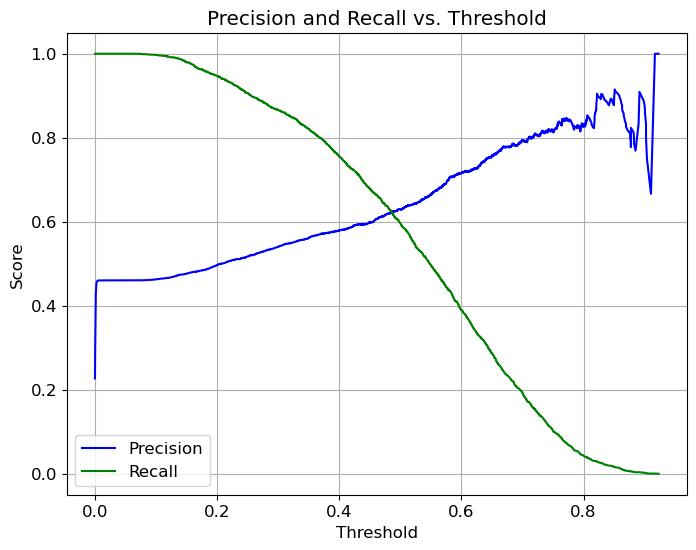

In [40]:
'''
Remove features: person_income, loan_int_rate, loan_percent_income
Finetuning to have better accuracy proportional to classes 
(limit class 0 dominating due to frequency)
Make custom predictions based on custom threshold
(determined through trial and error)
'''

features = ['person_income', 'loan_int_rate', 'loan_percent_income']

X_train_subset = X_train.drop(columns=features)
X_test_subset = X_test.drop(columns=features)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_subset, y_train_logistic)
y_prob = model.predict_proba(X_test_subset)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_logistic, y_prob)
optimal_threshold = 0.35
y_pred_new = (y_prob > optimal_threshold).astype(int)

accuracy = accuracy_score(y_test_logistic, y_pred_new)
print(f'Accuracy: {accuracy:.4f}')

# Plot confusion matrix
plt.rcParams.update({'font.size': 14, "figure.figsize": (5,3)})
ConfusionMatrixDisplay.from_predictions(y_test_logistic, y_pred_new)
plt.show()

# Plot Precision/Recall vs Threshold
plt.rcParams.update({'font.size': 12, "figure.figsize": (7,6)})
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Stage 2: Feature Contribution Analysis with SHAP

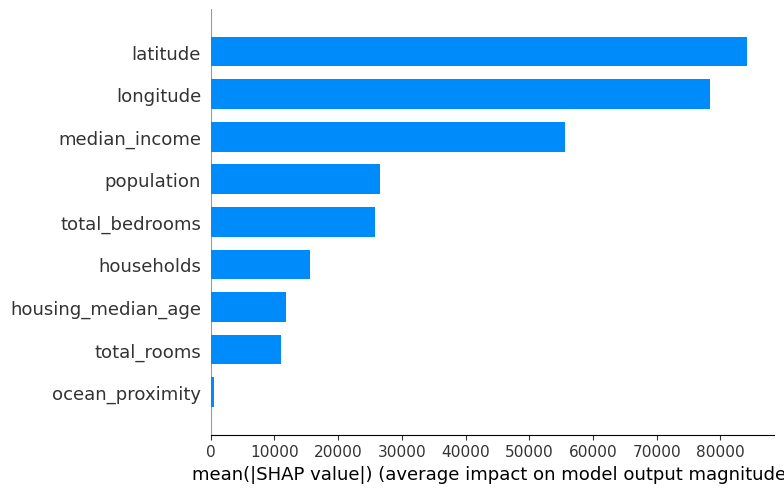

In [41]:
# Evaluate Feature Contribution with SHAP on Lin Reg Case 3 
# (best observed model)


input_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                  'population', 'households', 'median_income', 'ocean_proximity']

target = 'median_house_value'

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    housing_data_bedrooms_proportionally[input_features],
    housing_data_bedrooms_proportionally[target],
    test_size=0.25,
    random_state=5
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Linear Regression (for continuous targets)
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

# SHAP Explainer
explainer = shap.LinearExplainer(regressor, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


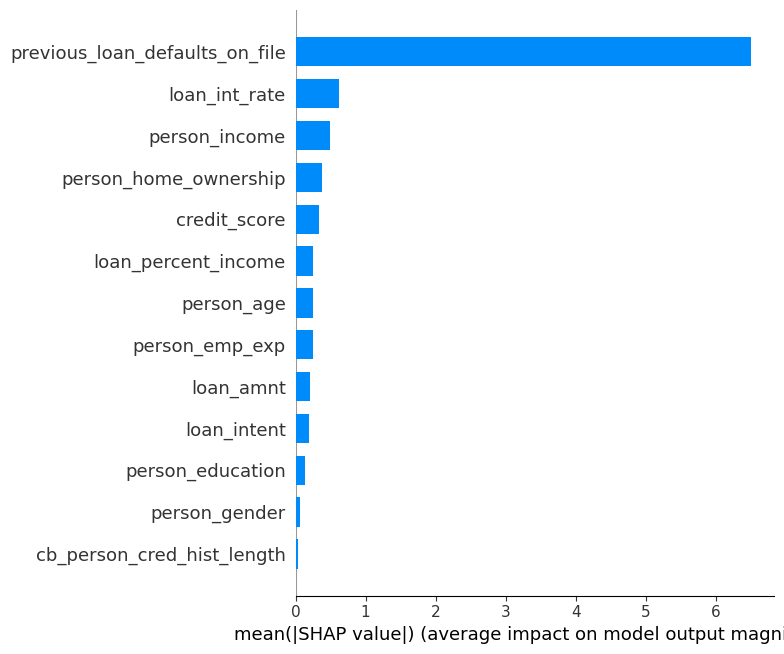

In [42]:
# Evaluate Feature Contribution with SHAP on Log Reg highest accuracy 
# (best observed model with accuracy)

input_features = ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp',
                 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income',
                 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file']

target = 'loan_status'

# Split, scale
X_train, X_test, y_train, y_test = \
train_test_split(loan_data[input_features], loan_data[target],
test_size=0.25,
random_state=5)

clf = LogisticRegression(max_iter=10000)  
clf.fit(X_train, y_train)

# Use SHAP for explanations
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Stage 3: Advanced Machine Learning Models

## Random Forests, Gradient Boosting, Decision Trees - Housing

In [43]:
# Generic Random Forest with 100 trees on original regression split

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=5)
rf_model.fit(X_train_lin_reg3, y_train_lin_reg3)
rf_pred = rf_model.predict(X_test_lin_reg3)

print(f'R2 score: {r2_score(y_test_lin_reg3, rf_pred)}')
print(f'CV score: {(cross_val_score(rf_model, X_train_lin_reg3, y_train_lin_reg3, cv=5, scoring='r2')).mean()}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg3, rf_pred))}')

R2 score: 0.7930395447282144
CV score: 0.7850103616131449
RMSE: 53227.34009547154


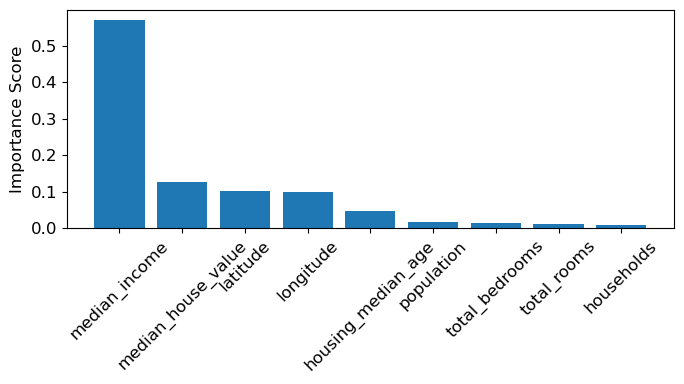

In [44]:
# Feature importances

feature_names = housing_data.columns.tolist()
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(7, 4))
plt.bar(range(X_train_lin_reg3.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_lin_reg3.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [45]:
# Experimenting with depth

depths = [5, 15, 20, 30]

for depth in depths:
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=5)
    rf_model.fit(X_train_lin_reg3, y_train_lin_reg3)
    rf_pred = rf_model.predict(X_test_lin_reg3)

    print(f'Depth: {depth}')
    print(f'R2 score: {r2_score(y_test_lin_reg3, rf_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg3, rf_pred))}\n')

Depth: 5
R2 score: 0.6743520306686969
RMSE: 66767.52313370397

Depth: 15
R2 score: 0.8165286619573715
RMSE: 50115.860595340884

Depth: 20
R2 score: 0.8199808235921554
RMSE: 49642.13640959059

Depth: 30
R2 score: 0.8201808913672443
RMSE: 49614.543369263454



In [46]:
# Stick with 30 trees and increase estimators

rf_model = RandomForestRegressor(n_estimators=200, max_depth=depth, random_state=5)
rf_model.fit(X_train_lin_reg3, y_train_lin_reg3)
rf_pred = rf_model.predict(X_test_lin_reg3)

print(f'R2 score: {r2_score(y_test_lin_reg3, rf_pred)}')
print(f'CV score: {(cross_val_score(rf_model, X_train_lin_reg3, y_train_lin_reg3, cv=5, scoring='r2')).mean()}')
print(f'Mean squared error: {mean_squared_error(y_test_lin_reg3, rf_pred)}')

R2 score: 0.8217437122136584
CV score: 0.8116361121183318
Mean squared error: 2440208945.2216163


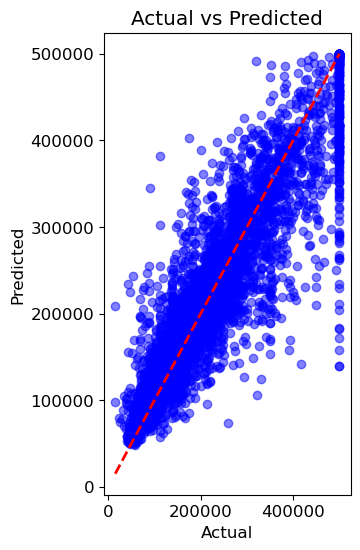

In [47]:
# Plotting results

# Plotting Predicted vs Actual (Test Set)
plt.subplot(1, 2, 2)
plt.scatter(y_test_lin_reg3, rf_pred, color='b', alpha=0.5)
plt.plot([min(y_test_lin_reg3), max(y_test_lin_reg3)], [min(y_test_lin_reg3), max(y_test_lin_reg3)], 'r--', lw=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Show the plots
plt.show()

In [48]:
# Gradient Boost

learning_rates = [0.01, 0.1, 0.25, 1]

for learning_rate in learning_rates:
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, max_depth=3, random_state=5)
    gbr.fit(X_train_lin_reg1, y_train_lin_reg1)
    gbr_pred = gbr.predict(X_test_lin_reg1)
    
    print(f'Learning rate: {learning_rate}')
    print(f'R2 score: {r2_score(y_test_lin_reg1, gbr_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg1, gbr_pred))}\n')

Learning rate: 0.01
R2 score: 0.4825111045738997
RMSE: 83614.92139297744

Learning rate: 0.1
R2 score: 0.7720416677135145
RMSE: 55495.91341559658

Learning rate: 0.25
R2 score: 0.8053943657677144
RMSE: 51275.62625005545

Learning rate: 1
R2 score: 0.7705261787040294
RMSE: 55680.078931222684



In [49]:
# Experimenting with depths for Gradient Boosting

depths = [3, 5, 10, 20]

for depth in depths:
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.25, max_depth=depth, random_state=5)
    gbr.fit(X_train_lin_reg1, y_train_lin_reg1)
    gbr_pred = gbr.predict(X_test_lin_reg1)
    
    print(f'Depth: {depth}')
    print(f'R2 score: {r2_score(y_test_lin_reg1, gbr_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg1, gbr_pred))}\n')

Depth: 3
R2 score: 0.8053943657677144
RMSE: 51275.62625005545

Depth: 5
R2 score: 0.8254401320605838
RMSE: 48562.99587303136

Depth: 10
R2 score: 0.8148056302927058
RMSE: 50020.39972039265

Depth: 20
R2 score: 0.7058203826698
RMSE: 63043.38992990234



In [50]:
# Decision Tree of different depths

depths = [1, 5, 10, 15, 20]

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=5)
    tree.fit(X_train_lin_reg1, y_train_lin_reg1)
    tree_pred = tree.predict(X_test_lin_reg1)
    
    print(f'Depth: {depth}')
    print(f'R2 score: {r2_score(y_test_lin_reg1, tree_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test_lin_reg1, tree_pred))}\n')    

Depth: 1
R2 score: 0.31128264423216534
RMSE: 96461.44914751677

Depth: 5
R2 score: 0.6345231316580218
RMSE: 70268.90983002186

Depth: 10
R2 score: 0.7280225068631525
RMSE: 60617.74153634201

Depth: 15
R2 score: 0.6689796720514323
RMSE: 66874.5081180361

Depth: 20
R2 score: 0.6507333868327029
RMSE: 68692.89264263934



## Random Forests, Gradient Boosting, Decision Trees - Loan

In [51]:
# Generic Random Forest with 100 trees on original regression split

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=5)
rf_model.fit(X_train_logistic, y_train_logistic)
rf_pred = rf_model.predict(X_test_logistic)

accuracy = accuracy_score(y_test_logistic, rf_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9210


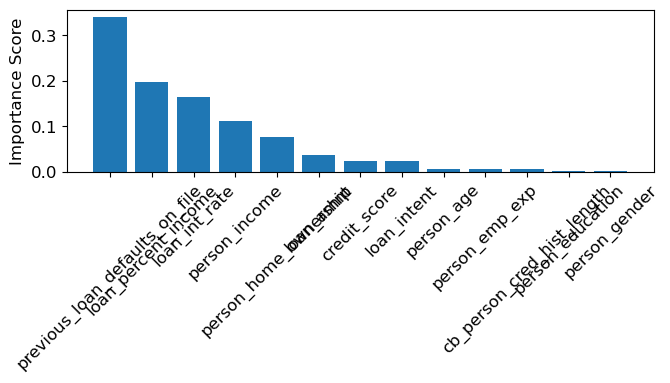

In [52]:
# Feature importances

feature_names = loan_data.columns.tolist()
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(7, 4))
plt.bar(range(X_train_logistic.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_logistic.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [53]:
# Experimenting with depth

depths = [5, 15, 20, 30]

for depth in depths:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=5)
    rf_model.fit(X_train_logistic, y_train_logistic)
    rf_pred = rf_model.predict(X_test_logistic)

    accuracy = accuracy_score(y_test_logistic, rf_pred)
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9132
Accuracy: 0.9234
Accuracy: 0.9251
Accuracy: 0.9253


In [54]:
# Stick with 20 trees and increase estimators

rf_model = RandomForestClassifier(n_estimators=500, max_depth=depth, random_state=5)
rf_model.fit(X_train_logistic, y_train_logistic)
rf_pred = rf_model.predict(X_test_logistic)

accuracy = accuracy_score(y_test_logistic, rf_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9262


In [55]:
# Gradient Boost

learning_rates = [0.01, 0.1, 0.25, 1]

for learning_rate in learning_rates:
    gbr = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=3, random_state=5)
    gbr.fit(X_train_logistic, y_train_logistic)
    gbr_pred = gbr.predict(X_test_logistic)
    
    print(f'Learning rate: {learning_rate}')
    accuracy = accuracy_score(y_test_logistic, gbr_pred)
    print(f'Accuracy: {accuracy:.4f}')

Learning rate: 0.01
Accuracy: 0.8926
Learning rate: 0.1
Accuracy: 0.9222
Learning rate: 0.25
Accuracy: 0.9274
Learning rate: 1
Accuracy: 0.9271


In [56]:
# Experimenting with Gradient Boost depths

depths = [3, 5, 10, 20]

for depth in depths:
    gbr = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_depth=depth, random_state=5)
    gbr.fit(X_train_logistic, y_train_logistic)
    gbr_pred = gbr.predict(X_test_logistic)
    
    print(f'Depth: {depth}')
    accuracy = accuracy_score(y_test_logistic, gbr_pred)
    print(f'Accuracy: {accuracy:.4f}')

Depth: 3
Accuracy: 0.9274
Depth: 5
Accuracy: 0.9321
Depth: 10
Accuracy: 0.9311
Depth: 20
Accuracy: 0.9262


In [57]:
# Gradient Boost Learning Rates

learning_rates = [0.01, 0.1, 0.25, 1]

for learning_rate in learning_rates:
    gbr = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=5, random_state=5)
    gbr.fit(X_train_logistic, y_train_logistic)
    gbr_pred = gbr.predict(X_test_logistic)
    
    print(f'Learning Rate: {learning_rate}')
    accuracy = accuracy_score(y_test_logistic, gbr_pred)
    print(f'Accuracy: {accuracy:.4f}')

Learning Rate: 0.01
Accuracy: 0.9117
Learning Rate: 0.1
Accuracy: 0.9266
Learning Rate: 0.25
Accuracy: 0.9321
Learning Rate: 1
Accuracy: 0.9223


In [58]:
# Decision Tree of different depths

depths = [1, 5, 10, 15, 20]

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=5)
    tree.fit(X_train_logistic, y_train_logistic)
    tree_pred = tree.predict(X_test_logistic)
    
    print(f'Depth: {depth}')
    accuracy = accuracy_score(y_test_logistic, tree_pred)
    print(f'Accuracy: {accuracy:.4f}') 

Depth: 1
Accuracy: 0.7727
Depth: 5
Accuracy: 0.9128
Depth: 10
Accuracy: 0.9186
Depth: 15
Accuracy: 0.9122
Depth: 20
Accuracy: 0.9017


## Neural Network - Housing

In [59]:
# General network

# Scale X
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_lin_reg3)
X_test = x_scaler.transform(X_test_lin_reg3)

# Scale y
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train_lin_reg3.values.reshape(-1, 1)).flatten()  # Make y 2D, then flatten
y_test = y_scaler.transform(y_test_lin_reg3.values.reshape(-1, 1)).flatten()


# Initialize model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  
])

model.compile(loss='mse',optimizer='adam',metrics=['mse'])

model.fit(X_train, y_train, epochs=100, validation_split=0.1)
loss, mse = model.evaluate(X_test, y_test)

/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746053341.373720  144341 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746053341.404902  144341 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746053341.405117  144341 cuda_

Epoch 1/100


I0000 00:00:1746053342.371131  145441 service.cc:146] XLA service 0x7105ac00b090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746053342.371148  145441 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2025-04-30 16:49:02.384345: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-30 16:49:02.430146: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


370/436 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.5035 - mse: 0.5032

I0000 00:00:1746053342.750288  145441 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4852 - mse: 0.4852 - val_loss: 0.3176 - val_mse: 0.3176
Epoch 2/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.2790 - mse: 0.2790 - val_loss: 0.2867 - val_mse: 0.2867
Epoch 3/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.2715 - mse: 0.2715 - val_loss: 0.2675 - val_mse: 0.2675
Epoch 4/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.2575 - mse: 0.2575 - val_loss: 0.2557 - val_mse: 0.2557
Epoch 5/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.2511 - mse: 0.2511 - val_loss: 0.2576 - val_mse: 0.2576
Epoch 6/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.2416 - mse: 0.2416 - val_loss: 0.2528 - val_mse: 0.2528
Epoch 7/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.2307 - mse: 0.2307 - val_loss: 0.2482 - val_mse: 0.2482
Epoch 8/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.2327 - mse: 0.2327 - val_loss: 0.2535 - val_mse: 0.2535
Epoch 9/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 47

In [60]:
# Corresponding metrics

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

mse_real = mean_squared_error(y_test_lin_reg3, y_pred)
rmse_real = np.sqrt(mse_real)
r2_real = r2_score(y_test_lin_reg3, y_pred)

print(f"Real RMSE: {rmse_real}")
print(f"Real R2: {r2_real}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
Real RMSE: 53359.74695396038
Real R2: 0.7920086058491802


In [61]:
# Experiment with layer sizes

# Bigger Network

# Scale X
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_lin_reg3)
X_test = x_scaler.transform(X_test_lin_reg3)

# Scale y
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train_lin_reg3.values.reshape(-1, 1)).flatten()  # Make y 2D, then flatten
y_test = y_scaler.transform(y_test_lin_reg3.values.reshape(-1, 1)).flatten()


# Initialize model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(loss='mse',optimizer='adam',metrics=['mse'])

model.fit(X_train, y_train, epochs=100, validation_split=0.1)
loss, mse = model.evaluate(X_test, y_test)


# Smaller Network

# Scale X
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_lin_reg3)
X_test = x_scaler.transform(X_test_lin_reg3)

# Scale y
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train_lin_reg3.values.reshape(-1, 1)).flatten()  # Make y 2D, then flatten
y_test = y_scaler.transform(y_test_lin_reg3.values.reshape(-1, 1)).flatten()


# Initialize model
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)  
])

model.compile(loss='mse',optimizer='adam',metrics=['mse'])

model.fit(X_train, y_train, epochs=100, validation_split=0.1)
loss, mse = model.evaluate(X_test, y_test)

Epoch 1/100


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4388 - mse: 0.4388 - val_loss: 0.2817 - val_mse: 0.2817
Epoch 2/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.2691 - mse: 0.2691 - val_loss: 0.2530 - val_mse: 0.2530
Epoch 3/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.2660 - mse: 0.2660 - val_loss: 0.2503 - val_mse: 0.2503
Epoch 4/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 0.2474 - mse: 0.2474 - val_loss: 0.2777 - val_mse: 0.2777
Epoch 5/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.2425 - mse: 0.2425 - val_loss: 0.2364 - val_mse: 0.2364
Epoch 6/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.2315 - mse: 0.2315 - val_loss: 0.2246 - val_mse: 0.2246
Epoch 7/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.2177 - mse: 0.2177 - val_loss: 0.2252 - val_mse: 0.2252
Epoch 8/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.2229 - mse: 0.2229 - val_loss: 0.2202 - val_mse: 0.2202
Epoch 9/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 51

/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5865 - mse: 0.5865 - val_loss: 0.3400 - val_mse: 0.3400
Epoch 2/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.3257 - mse: 0.3257 - val_loss: 0.2935 - val_mse: 0.2935
Epoch 3/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.2864 - mse: 0.2864 - val_loss: 0.2796 - val_mse: 0.2796
Epoch 4/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.2649 - mse: 0.2649 - val_loss: 0.2738 - val_mse: 0.2738
Epoch 5/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.2682 - mse: 0.2682 - val_loss: 0.2677 - val_mse: 0.2677
Epoch 6/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.2487 - mse: 0.2487 - val_loss: 0.2641 - val_mse: 0.2641
Epoch 7/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.2506 - mse: 0.2506 - val_loss: 0.2605 - val_mse: 0.2605
Epoch 8/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.2499 - mse: 0.2499 - val_loss: 0.2541 - val_mse: 0.2541
Epoch 9/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 51

In [62]:
# Putting it all together for more optimal model

# Scale X
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_lin_reg3)
X_test = x_scaler.transform(X_test_lin_reg3)

# Scale y
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train_lin_reg3.values.reshape(-1, 1)).flatten()  # Make y 2D, then flatten
y_test = y_scaler.transform(y_test_lin_reg3.values.reshape(-1, 1)).flatten()


# Initialize model
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.1),            
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dense(1)
])

model.compile(loss='mse',optimizer='adam',metrics=['mse'])

model.fit(X_train, y_train, epochs=200, validation_split=0.1)
loss, mse = model.evaluate(X_test, y_test)

Epoch 1/200


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4965 - mse: 0.4508 - val_loss: 0.3435 - val_mse: 0.3006
Epoch 2/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.3552 - mse: 0.3131 - val_loss: 0.3081 - val_mse: 0.2680
Epoch 3/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.3218 - mse: 0.2822 - val_loss: 0.3160 - val_mse: 0.2781
Epoch 4/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.2941 - mse: 0.2565 - val_loss: 0.3032 - val_mse: 0.2670
Epoch 5/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.2892 - mse: 0.2534 - val_loss: 0.2781 - val_mse: 0.2434
Epoch 6/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.2921 - mse: 0.2577 - val_loss: 0.2735 - val_mse: 0.2403
Epoch 7/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.2842 - mse: 0.2513 - val_loss: 0.2687 - val_mse: 0.2365
Epoch 8/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.2768 - mse: 0.2448 - val_loss: 0.2818 - val_mse: 0.2504
Epoch 9/200
436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 58

In [63]:
# Evaluation

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

mse_real = mean_squared_error(y_test_lin_reg3, y_pred)
rmse_real = np.sqrt(mse_real)
r2_real = r2_score(y_test_lin_reg3, y_pred)

print(f"Real RMSE: {rmse_real}")
print(f"Real R2: {r2_real}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
Real RMSE: 52191.620114460646
Real R2: 0.8010154305125149


## Neural Network - Loan

In [64]:
# General network

# Scale X
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_logistic)
X_test = x_scaler.transform(X_test_logistic)

y_train = y_train_logistic.values  # Make y 2D, then flatten
y_test = y_test_logistic.values


# Initialize model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')  
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, validation_split=0.1)
loss, mse = model.evaluate(X_test, y_test)

Epoch 1/100


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


950/950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8509 - loss: 0.3151 - val_accuracy: 0.8975 - val_loss: 0.2178
Epoch 2/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.9008 - loss: 0.2169 - val_accuracy: 0.9019 - val_loss: 0.2087
Epoch 3/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.9078 - loss: 0.2082 - val_accuracy: 0.9028 - val_loss: 0.2067
Epoch 4/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.9070 - loss: 0.2044 - val_accuracy: 0.9058 - val_loss: 0.2020
Epoch 5/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 521us/step - accuracy: 0.9081 - loss: 0.2013 - val_accuracy: 0.9034 - val_loss: 0.1985
Epoch 6/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.9144 - loss: 0.1931 - val_accuracy: 0.9043 - val_loss: 0.1968
Epoch 7/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.9166 - loss: 0.1881 - val_accuracy: 0.9055 - val_loss: 0.1991
Epoch 8/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.9140 - loss: 0.1916 - val_ac

In [65]:
# Experiment with layer sizes

# Bigger Network
# Scale x
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_logistic)
X_test = x_scaler.transform(X_test_logistic)      

y_train = y_train_logistic.values 
y_test = y_test_logistic.values   

# Large Model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])  

model.fit(X_train, y_train, epochs=100, validation_split=0.1)
loss, accuracy = model.evaluate(X_test, y_test) 

# Smaller Network
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(loss='binary_crossentropy',  
              optimizer='adam',
              metrics=['accuracy']) 

model.fit(X_train, y_train, epochs=100, validation_split=0.1)
loss, accuracy = model.evaluate(X_test, y_test)


Epoch 1/100


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


950/950 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8658 - loss: 0.2887 - val_accuracy: 0.8984 - val_loss: 0.2123
Epoch 2/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.9081 - loss: 0.2039 - val_accuracy: 0.9037 - val_loss: 0.2081
Epoch 3/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.9145 - loss: 0.1922 - val_accuracy: 0.9049 - val_loss: 0.1995
Epoch 4/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.9149 - loss: 0.1931 - val_accuracy: 0.9067 - val_loss: 0.1988
Epoch 5/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.9138 - loss: 0.1914 - val_accuracy: 0.9064 - val_loss: 0.1980
Epoch 6/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - accuracy: 0.9158 - loss: 0.1877 - val_accuracy: 0.9076 - val_loss: 0.1976
Epoch 7/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.9203 - loss: 0.1837 - val_accuracy: 0.9067 - val_loss: 0.1938
Epoch 8/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.9177 - loss: 0.1836 - val_ac

In [66]:
# Putting it all together for more optimal model

# Scale x
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_logistic)
X_test = x_scaler.transform(X_test_logistic)      

y_train = y_train_logistic.values 
y_test = y_test_logistic.values   

# Large Model
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])  

model.fit(X_train, y_train, epochs=200, validation_split=0.1)
loss, accuracy = model.evaluate(X_test, y_test) 


Epoch 1/200


/home/andrewebes05/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


950/950 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8461 - loss: 0.5394 - val_accuracy: 0.8954 - val_loss: 0.2842
Epoch 2/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - accuracy: 0.9014 - loss: 0.2750 - val_accuracy: 0.8996 - val_loss: 0.2423
Epoch 3/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - accuracy: 0.9057 - loss: 0.2508 - val_accuracy: 0.9016 - val_loss: 0.2395
Epoch 4/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.9042 - loss: 0.2408 - val_accuracy: 0.9040 - val_loss: 0.2347
Epoch 5/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.9046 - loss: 0.2396 - val_accuracy: 0.9028 - val_loss: 0.2332
Epoch 6/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - accuracy: 0.9074 - loss: 0.2368 - val_accuracy: 0.9034 - val_loss: 0.2275
Epoch 7/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - accuracy: 0.9083 - loss: 0.2354 - val_accuracy: 0.9043 - val_loss: 0.2251
Epoch 8/200
950/950 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.9071 - loss: 0.2337 - val_ac